## Setup Environment

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import plotly.io as pio
from IPython.core.display import HTML
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
import re
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from plotly.subplots import make_subplots
from scipy.stats import zscore


## Upload Data

In [2]:
path = 'C:\\Users\\steve\\OneDrive\\Desktop\\Github\\NFL Big Data Bowl\\0. Data'
allFiles = [f for f in listdir(path) if isfile(join(path, f))]

In [3]:
# Upload files
games = pd.read_csv("../0. Data/games.csv")
players = pd.read_csv("../0. Data/players.csv")
plays = pd.read_csv("../0. Data/plays.csv")

weeklyData = pd.DataFrame()

# Go through all weekly data and upload it
for file in allFiles:
    if "week" in file:
        tempWeek = pd.read_csv("../0. Data/"+file)
        tempWeek['week'] = re.findall(r'\d+', file)[0]
        weeklyData = pd.concat([weeklyData, tempWeek])

# merge with games to add home/away team indicators
weeklyData = weeklyData.merge(games[['gameId','homeTeamAbbr','visitorTeamAbbr']], on='gameId')

In [4]:
weeklyData.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,position,frameId,team,gameId,playId,playDirection,route,week,homeTeamAbbr,visitorTeamAbbr
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,...,QB,1,away,2018090600,75,left,NaN,1,PHI,ATL
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,...,SS,1,home,2018090600,75,left,NaN,1,PHI,ATL
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,...,FS,1,home,2018090600,75,left,NaN,1,PHI,ATL
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL


## Data Wrangling

### WR Route Pivot

In [5]:
weeklyData.columns

Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId',
       'playId', 'playDirection', 'route', 'week', 'homeTeamAbbr',
       'visitorTeamAbbr'],
      dtype='object')

In [6]:
weeklyData['week'].value_counts().sort_index()

1      986022
10     964889
11     932240
12    1024868
13    1172517
14    1161644
15    1081222
16    1144037
17    1049265
2     1231793
3     1168345
4     1205527
5     1171908
6     1072563
7      982583
8     1001501
9      958464
Name: week, dtype: int64

In [32]:
# Only retain first frame of every play - get WR that lined up at the time of the snap
wrLinedUp = weeklyData[(weeklyData['position']=='WR')&(weeklyData['frameId']==1)]

# Get some descriptive stats and the 50th percentile of snaps played
print("Total Number of WR: ", wrLinedUp.displayName.value_counts().shape[0])
print("Average Snap per WR: ",wrLinedUp.displayName.value_counts().mean())
quantile = wrLinedUp.displayName.value_counts().quantile(0.25)
print("50th Percentile fo Snaps Played: ", quantile)

Total Number of WR:  227
Average Snap per WR:  231.71806167400882
50th Percentile fo Snaps Played:  50.0


In [33]:
# Get list of players that meet minimum snap requirement
wrLinedUpSnapCount = wrLinedUp.displayName.value_counts()
wrLinedUpSnapCountRetainPlayers = wrLinedUpSnapCount[wrLinedUpSnapCount>quantile].reset_index()['index'].tolist()

In [34]:
# Filter out dataframe with filtered list of players
wrLinedUpFiltered = wrLinedUp[wrLinedUp['displayName'].isin(wrLinedUpSnapCountRetainPlayers)]

In [35]:
wrLinedUpFiltered.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,position,frameId,team,gameId,playId,playDirection,route,week,homeTeamAbbr,visitorTeamAbbr
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,...,WR,1,away,2018090600,75,left,HITCH,1,PHI,ATL
831,2018-09-07T01:09:09.700Z,51.00,24.17,2.50,2.77,0.26,261.61,207.55,None,2552418.0,...,WR,1,away,2018090600,146,left,CROSS,1,PHI,ATL
836,2018-09-07T01:09:09.700Z,49.88,9.96,0.00,0.00,0.00,278.36,325.75,None,2557034.0,...,WR,1,away,2018090600,146,left,HITCH,1,PHI,ATL
838,2018-09-07T01:09:09.700Z,50.05,38.03,0.00,0.00,0.00,256.84,103.45,None,2560854.0,...,WR,1,away,2018090600,146,left,HITCH,1,PHI,ATL


In [36]:
# Re format the dataframe to get the number of route ran by WR and route type
wrRoutePivot = wrLinedUpFiltered.groupby(['displayName','route']).size().reset_index()
wrRoutePivot.rename({0:'count'}, axis=1, inplace=True)

# Finalize the format and convert the raw number to percentage
wrRoutePivot = wrRoutePivot.pivot(index='displayName', columns='route', values='count').fillna(0)
wrRoutePivot = wrRoutePivot.div(wrRoutePivot.sum(axis=1), axis=0)

In [37]:
wrRoutePivot.head()

route,ANGLE,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT,WHEEL,undefined
displayName,,,,,,,,,,,,,
A.J. Green,0.000000,0.056180,0.127341,0.011236,0.235955,0.123596,0.067416,0.078652,0.146067,0.037453,0.116105,0.0,0.0
Adam Humphries,0.002053,0.032854,0.067762,0.127310,0.092402,0.182752,0.168378,0.119097,0.078029,0.069815,0.059548,0.0,0.0
Adam Thielen,0.000000,0.068841,0.097826,0.028986,0.143116,0.253623,0.085145,0.166667,0.043478,0.034420,0.077899,0.0,0.0
Albert Wilson,0.000000,0.017391,0.252174,0.060870,0.182609,0.113043,0.104348,0.052174,0.060870,0.086957,0.069565,0.0,0.0
Aldrick Robinson,0.000000,0.055901,0.124224,0.024845,0.316770,0.186335,0.031056,0.055901,0.111801,0.006211,0.086957,0.0,0.0


In [38]:
wrRoutePivot.shape

(169, 13)

<AxesSubplot:xlabel='route', ylabel='displayName'>

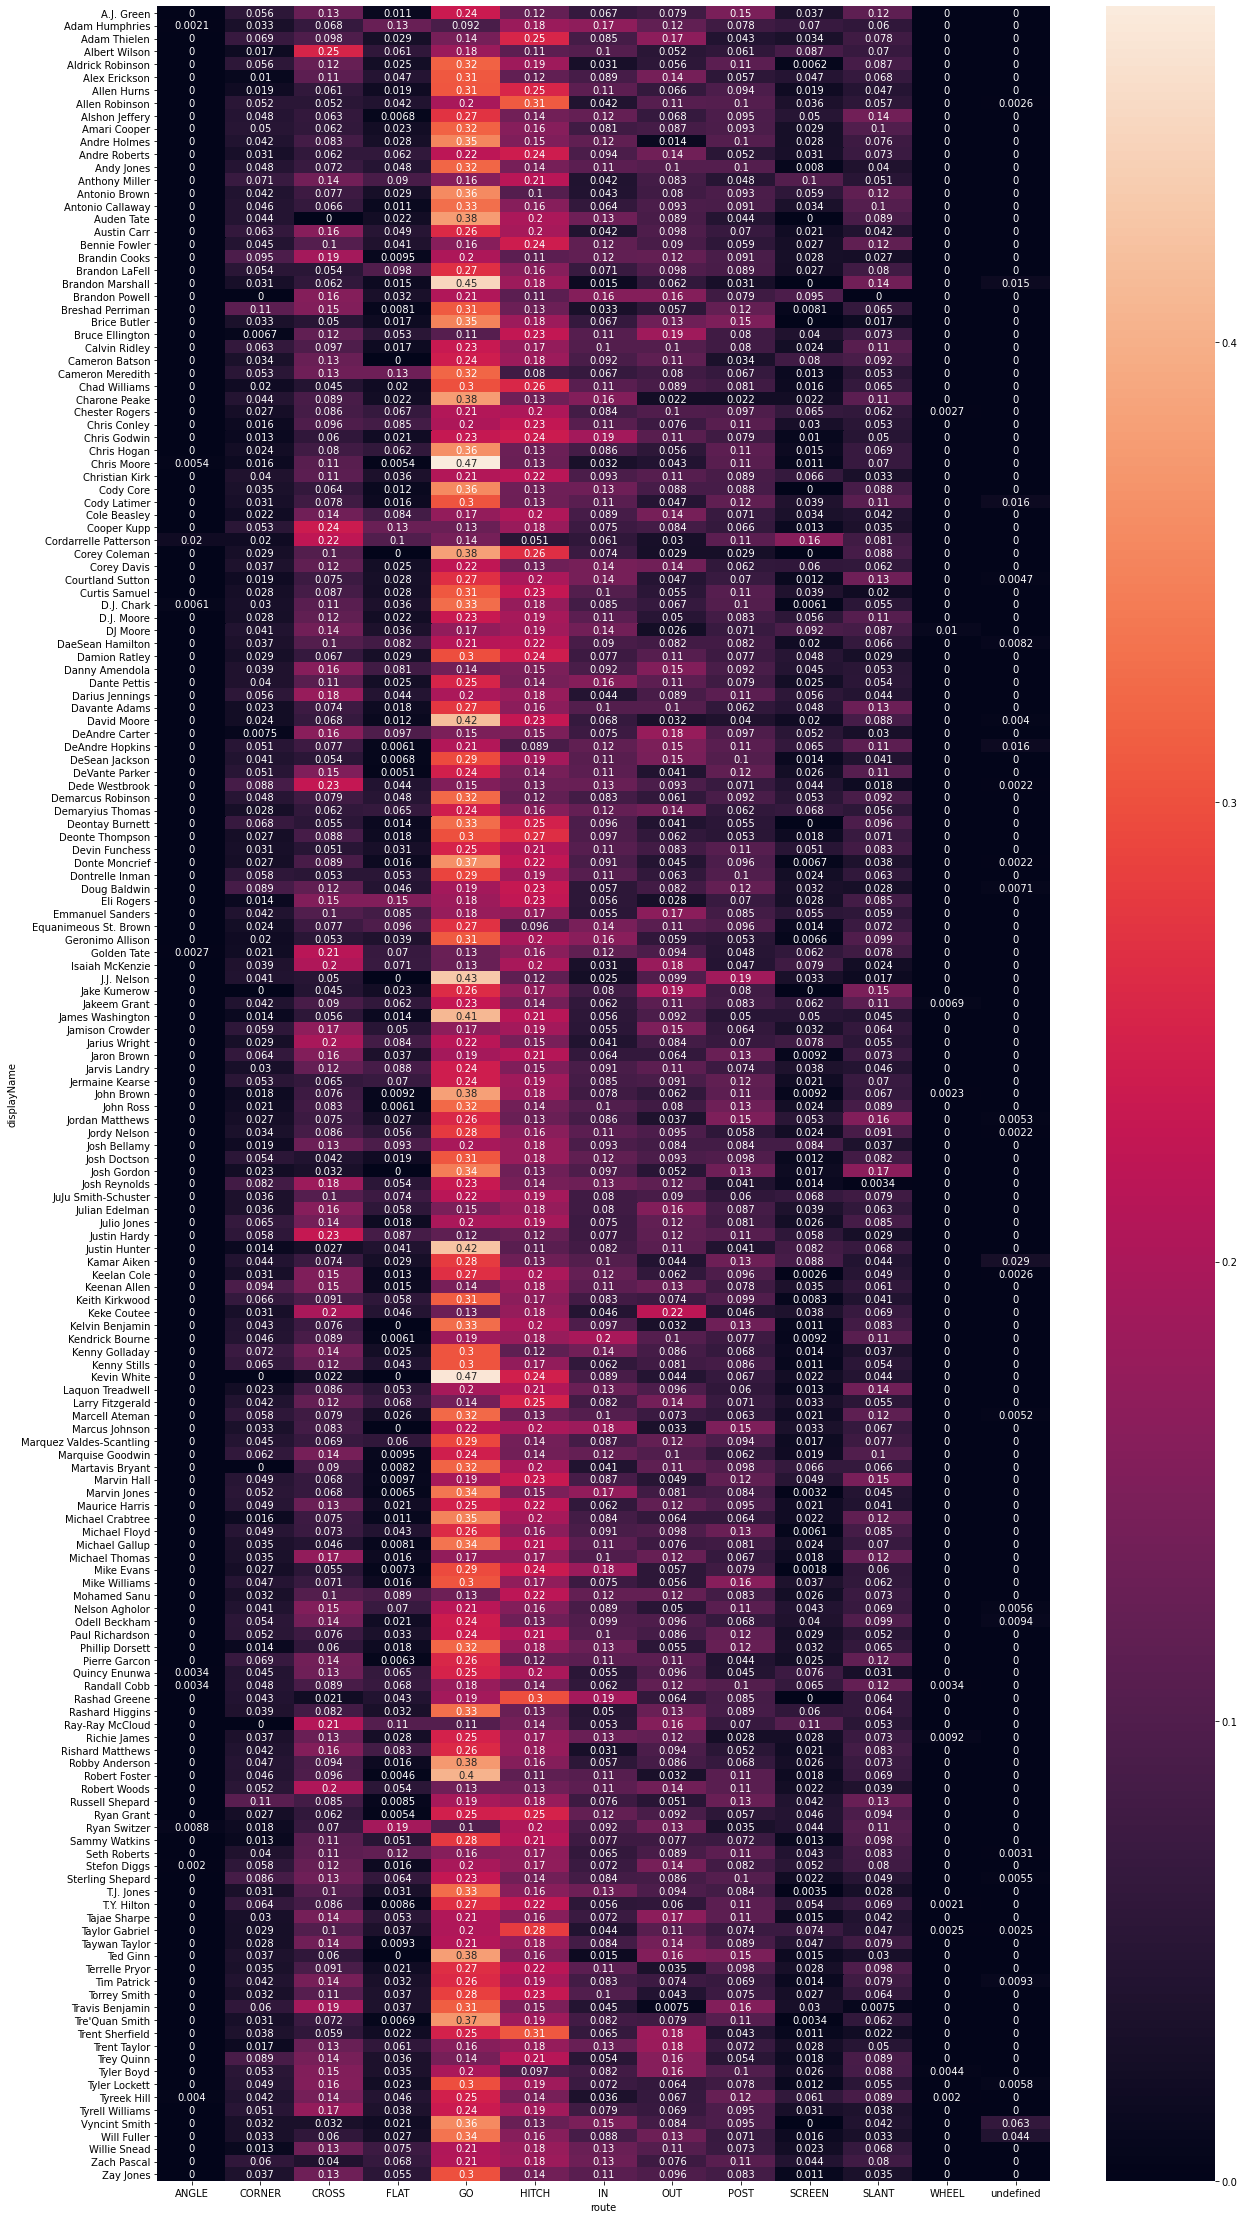

In [39]:
fig, ax = plt.subplots(figsize = (20, 40))
sn.heatmap(wrRoutePivot, annot = True)

The main thing that pops out here, is how seldomly Angle, Wheel and Undefined routes are ran. So to clean up the analysis, I will remove them and recalculated the pivot above

In [40]:
# Re format the dataframe to get the number of route ran by WR and route type
wrRoutePivotFiltered = wrLinedUpFiltered.groupby(['displayName','route']).size().reset_index()
wrRoutePivotFiltered.rename({0:'count'}, axis=1, inplace=True)


# Finalize the format and convert the raw number to percentage
wrRoutePivotFiltered = wrRoutePivotFiltered.pivot(index='displayName', columns='route', values='count').fillna(0)
wrRoutePivotFiltered = wrRoutePivotFiltered[[x for x in wrRoutePivotFiltered if x not in ['ANGLE','WHEEL','undefined']]]
wrRoutePivotFiltered = wrRoutePivotFiltered.div(wrRoutePivotFiltered.sum(axis=1), axis=0)

In [41]:
wrRoutePivotFiltered.head()

route,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT
displayName,,,,,,,,,,
A.J. Green,0.056180,0.127341,0.011236,0.235955,0.123596,0.067416,0.078652,0.146067,0.037453,0.116105
Adam Humphries,0.032922,0.067901,0.127572,0.092593,0.183128,0.168724,0.119342,0.078189,0.069959,0.059671
Adam Thielen,0.068841,0.097826,0.028986,0.143116,0.253623,0.085145,0.166667,0.043478,0.034420,0.077899
Albert Wilson,0.017391,0.252174,0.060870,0.182609,0.113043,0.104348,0.052174,0.060870,0.086957,0.069565
Aldrick Robinson,0.055901,0.124224,0.024845,0.316770,0.186335,0.031056,0.055901,0.111801,0.006211,0.086957


### WR Speed, Weight and Height

In [43]:
wrMaxSpeed = weeklyData[weeklyData.displayName.isin(wrLinedUpSnapCountRetainPlayers)].groupby(['displayName']).agg({'s':'max'})

In [48]:
wrMaxSpeed.sort_values(['s'], ascending=False)

,s
displayName,
Tre'Quan Smith,12.54
Marquez Valdes-Scantling,10.99
Tyreek Hill,10.94
Jakeem Grant,10.87
Courtland Sutton,10.86
...,...
Andre Roberts,8.96
Trent Taylor,8.94
Jaron Brown,8.94


array([[<AxesSubplot:title={'center':'s'}>]], dtype=object)

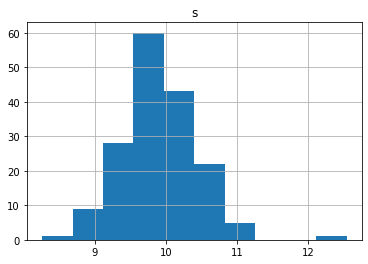

In [49]:
wrMaxSpeed.hist()

In [51]:
players.height.value_counts()

73      159
72      153
74      141
75      136
71      127
76       90
70       81
77       67
6-2      42
78       37
69       37
6-0      33
5-10     32
6-1      29
5-11     27
6-3      25
6-4      25
68       18
6-5      11
5-9       9
79        9
80        3
67        3
6-7       2
66        2
6-6       2
5-7       1
5-6       1
5-8       1
Name: height, dtype: int64

In [53]:
players[players.height.str.contains("-")].height.value_counts()

6-2     42
6-0     33
5-10    32
6-1     29
5-11    27
6-3     25
6-4     25
6-5     11
5-9      9
6-7      2
6-6      2
5-8      1
5-7      1
5-6      1
Name: height, dtype: int64

In [70]:
players.height.str.split("-").str[0]

0       72
1       70
2       69
3       73
4       75
        ..
1298     6
1299     6
1300    78
1301    69
1302     6
Name: height, Length: 1303, dtype: object

In [78]:
players['correctedHeight'] = np.where(players.height.str.contains("-"),
         ((players.height.str.split("-").str[0]).astype('int64')*12)+(players.height.str.split("-").str[1]).astype('float'),
         players.height)

players['correctedHeight'] = players['correctedHeight'].astype('int64')

In [79]:
players['correctedHeight'].value_counts()

73    188
72    186
74    183
75    161
71    154
76    115
70    113
77     78
69     46
78     39
68     19
79     11
67      4
80      3
66      3
Name: correctedHeight, dtype: int64

In [80]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,Corrected Height,correctedHeight
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant,72,72
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford,70,70
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen,69,69
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones,73,73
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell,75,75


In [136]:
wrStats = players[['displayName','weight','correctedHeight']].merge(wrMaxSpeed, on='displayName', how='right')

In [137]:
wrStats.rename({'s':'maxSpeed'}, axis=1, inplace=True)
wrStats.set_index(["displayName"], inplace=True)

In [138]:
wrStats.isna().sum()

weight             2
correctedHeight    2
maxSpeed           0
dtype: int64

In [139]:
wrStats.correctedHeight.fillna((wrStats.correctedHeight.mean()), inplace=True)
wrStats.weight.fillna((wrStats.weight.mean()), inplace=True)

In [145]:
wrDistanceMatrix = wrRoutePivotFiltered.merge(wrStats,left_index=True, right_index=True, how='left')

In [146]:
wrDistanceMatrixNormed = wrDistanceMatrix.apply(zscore)

In [147]:
wrDistanceMatrixNormed

,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT,weight,correctedHeight,maxSpeed
displayName,,,,,,,,,,,,,
A.J. Green,0.781050,0.424099,-0.865439,-0.267848,-1.204528,-0.693400,-0.370217,2.026652,0.157626,1.371196,0.554623,1.395965,0.638043
Adam Humphries,-0.356453,-0.793182,2.637568,-2.014939,0.123900,2.088720,0.634466,-0.268827,1.416938,-0.376856,-0.445355,-0.729423,0.102650
Adam Thielen,1.400266,-0.180342,-0.330980,-1.399234,1.696973,-0.206523,1.802981,-1.442672,0.040127,0.187751,-0.112029,0.545810,-0.165046
Albert Wilson,-1.116021,2.980593,0.629084,-0.917955,-1.439991,0.320824,-1.023985,-0.854539,2.075450,-0.070375,-0.445355,-1.579579,1.383769
Aldrick Robinson,0.767397,0.360260,-0.455664,0.717009,0.195481,-1.691908,-0.931968,0.867850,-1.052730,0.468323,-1.112006,-1.154501,0.504195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vyncint Smith,-0.318009,-1.493439,-0.527112,1.512208,-0.953803,1.775081,-0.092787,0.506757,-1.293360,-0.833026,0.021301,0.970887,-0.451863
Will Fuller,-0.280110,-0.889084,-0.338504,1.128969,-0.243417,-0.019533,1.093463,-0.386399,-0.625406,-1.157058,-1.178671,-0.304346,1.135194
Willie Snead,-1.353713,0.536556,1.060227,-0.638821,0.008250,0.965401,0.286853,-0.455080,-0.419496,-0.129105,0.221297,-0.729423,-1.121104


## K-Means Clustering

We'll start by intializing a random k means and plotting a dimension-reduced dataset, together with the newly obtained clusters. We will then try to determine the optimal number of clusters later

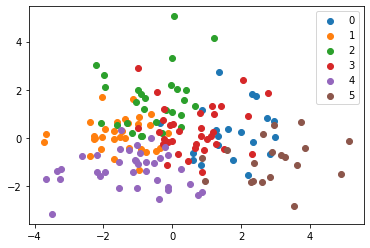

In [203]:
## Initialize the kmeans with 6 clusters
k = 6
kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42)
labels = kmeans.fit_predict(wrDistanceMatrixNormed)

# Reduce dimensionality of data to 2 dimensions and show initial results
pca = PCA(2)
pcaData = pca.fit_transform(wrDistanceMatrixNormed)
 
unique_label = np.unique(labels)
 
#plotting the results: 
for label in unique_label:
    plt.scatter(pcaData[labels == label, 0] , pcaData[labels == label, 1] , label = label)

plt.legend()
plt.show()

### Determining Optimal k

#### Elbow Method

We will use the concept of inertia to determine what is the optimal number of cluster for our analysis. Inertia is a performance metric is the mean squared distance between each instance and its closest centroid

In [152]:
# Create set of k means and obtain inertia for each set
kmeans_per_k = [KMeans(init="k-means++", n_clusters=k, random_state=42).fit(wrDistanceMatrixNormed)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

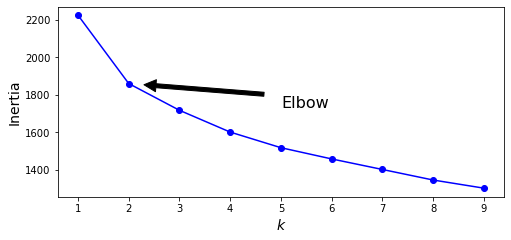

In [153]:
# For each set, plot the value of k and its corresponding intertia
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.show()

In the example above, the elbow appears at k=2. k=3 or k=4 could also be decent choices but the sharpest cut occurs at k=2. Presumably, the clusters within our dataset are not overly distinct, but let's try out a few other methods to see if the results are any different.

#### Silhouette Score

The silhouette score is usually a more precise approach to determine k. The silhouette score is the mean silhouette coefficient at each instance. The coefficient varies from +1 to -1, with a +1 score indicating that the instance is well inside its own cluster and far from other clusters.

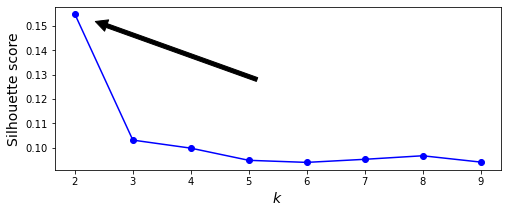

In [155]:
silhouette_scores = [silhouette_score(wrDistanceMatrixNormed, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.annotate(' ', xy=(2, silhouette_scores[0]), xytext=(0.55, 0.55),textcoords='figure fraction',
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.show()

As we can see from our silhouette plot, k=2 corresponds to the highest score, followed by k=3. Overall, we also see that the silhouette scores are fairly low, which, again, indicates that the clusters in the dataset are not well defined

#### Silhouette Diagram

Lastly, we can use the Silhouette Diagram for one last identification of the optimal k. The diagram plots every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. Each diagram contains one knife per cluster, and the height of the knife represents the total number of instances contained in the cluster, and the width the sorted silhouette coefficients of the instances in the cluster. Ideally we want wider knives, that are all above the mean silhouette coefficient.

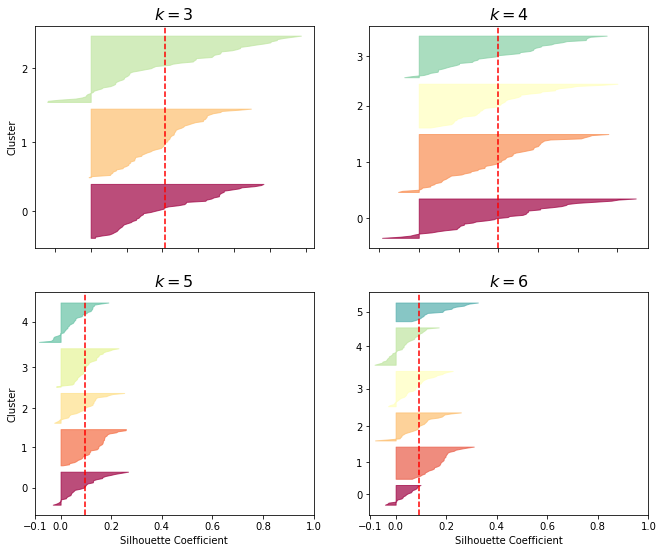

In [159]:
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(wrDistanceMatrixNormed, y_pred)

    padding = len(wrRoutePivot) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The diagram corresponding to k=3 appears to be the best, where we have thicker knives, all of which are above the dashed line. However, much like we noted in the elbow method analysis, the cluster do not appear to be very distinct. But for the sake of our analysis, let's move forward with k=3

## Finalizing and Summarizing Clusters

First, let's visualize out finalized set of clusters

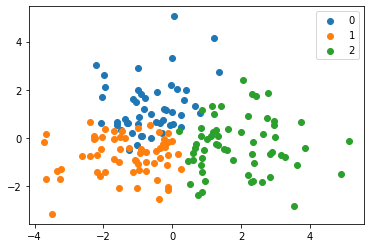

In [200]:
## Initialize the kmeans with 5 clusters
k = 3
kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42)
labels = kmeans.fit_predict(wrDistanceMatrixNormed)

# Reduce dimensionality of data to 2 dimensions and show initial results
pca = PCA(2)
pcaData = pca.fit_transform(wrDistanceMatrixNormed)
 
unique_label = np.unique(labels)
 
#plotting the results: 
for label in unique_label:
    plt.scatter(pcaData[labels == label, 0] , pcaData[labels == label, 1] , label = label)

plt.legend()
plt.show()

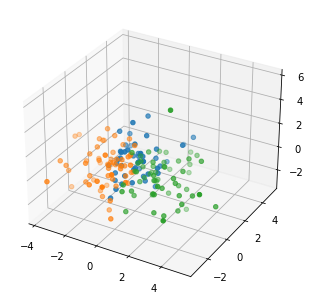

In [202]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
pca = PCA(3)
pcaData = pca.fit_transform(wrDistanceMatrixNormed)

fig = pyplot.figure()
ax = Axes3D(fig)

for label in unique_label:
    ax.scatter(pcaData[labels == label, 0] , pcaData[labels == label, 1], pcaData[labels == label, 2] , label = label)
    
pyplot.show()


Now, for each cluster, let us look at the route composition and determine any broader pattern observed

In [164]:
wrRoutePivotwLabels = wrDistanceMatrix.copy()
wrRoutePivotwLabels['Cluster'] = labels
wrRoutePivotwLabels.head()

,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT,weight,correctedHeight,maxSpeed,Cluster
displayName,,,,,,,,,,,,,,
A.J. Green,0.056180,0.127341,0.011236,0.235955,0.123596,0.067416,0.078652,0.146067,0.037453,0.116105,210.0,76.0,10.24,0
Adam Humphries,0.032922,0.067901,0.127572,0.092593,0.183128,0.168724,0.119342,0.078189,0.069959,0.059671,195.0,71.0,9.96,2
Adam Thielen,0.068841,0.097826,0.028986,0.143116,0.253623,0.085145,0.166667,0.043478,0.034420,0.077899,200.0,74.0,9.82,2
Albert Wilson,0.017391,0.252174,0.060870,0.182609,0.113043,0.104348,0.052174,0.060870,0.086957,0.069565,195.0,69.0,10.63,2
Aldrick Robinson,0.055901,0.124224,0.024845,0.316770,0.186335,0.031056,0.055901,0.111801,0.006211,0.086957,185.0,70.0,10.17,0


In [165]:
clusterSummary = wrRoutePivotwLabels.groupby(
    ['Cluster']).agg({i:'mean' for i in wrRoutePivotwLabels.columns}).drop(['Cluster'], axis=1)

In [166]:
clusterSummary.head()

,CORNER,CROSS,FLAT,GO,HITCH,IN,OUT,POST,SCREEN,SLANT,weight,correctedHeight,maxSpeed
Cluster,,,,,,,,,,,,,
0,0.042453,0.091961,0.022287,0.319904,0.174839,0.076847,0.077428,0.100814,0.026738,0.066728,195.979592,72.571429,10.322857
1,0.037192,0.079148,0.029311,0.280049,0.184821,0.112922,0.082281,0.084842,0.023248,0.086187,212.870968,74.370968,9.673548
2,0.041497,0.147014,0.065447,0.184474,0.172322,0.084652,0.118633,0.075494,0.049287,0.061182,194.772682,71.123866,9.806667


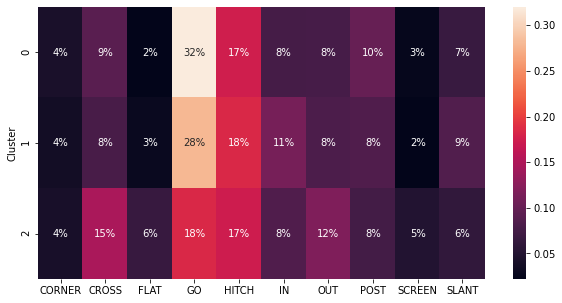

In [169]:
fig, ax = plt.subplots(figsize = (10, 5))
res = sn.heatmap(clusterSummary.iloc[:,:-3], annot = True)
for t in res.texts: t.set_text("{:.0%}".format(float(t.get_text())))


In [177]:
clusterSummary.iloc[:,-3:]

,weight,correctedHeight,maxSpeed
Cluster,,,
0,195.979592,72.571429,10.322857
1,212.870968,74.370968,9.673548
2,194.772682,71.123866,9.806667


In [179]:
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'},{'type':'domain'}, {'type':'domain'}]])

for i in range(0,clusterSummary.iloc[:,:-3].shape[0]):
    dfTemp = clusterSummary.iloc[:,:-3][i:i+1].stack().reset_index().rename({'level_1':'Route',0:'Percent'}, axis=1)
    fig.add_trace(go.Pie(labels=dfTemp['Route'], values=dfTemp['Percent'], name="Cluster ".format(i), sort=False), 1, i+1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout( title_text="WR Route Distribution by Cluster")

fig.update_layout(
    width=1000,
    height=500)

fig.show()


In [190]:
wrRoutePivotwLabels[wrRoutePivotwLabels.Cluster==0].index.unique()

Index(['A.J. Green', 'Aldrick Robinson', 'Amari Cooper', 'Antonio Brown',
       'Antonio Callaway', 'Breshad Perriman', 'Brice Butler', 'Calvin Ridley',
       'Chris Hogan', 'Chris Moore', 'Corey Coleman', 'Curtis Samuel',
       'D.J. Chark', 'Damion Ratley', 'DeSean Jackson', 'Demarcus Robinson',
       'Deontay Burnett', 'Deonte Thompson', 'Donte Moncrief', 'J.J. Nelson',
       'James Washington', 'John Brown', 'John Ross', 'Justin Hunter',
       'Keelan Cole', 'Keith Kirkwood', 'Kenny Stills',
       'Marquez Valdes-Scantling', 'Marquise Goodwin', 'Martavis Bryant',
       'Marvin Hall', 'Michael Gallup', 'Mike Williams', 'Paul Richardson',
       'Phillip Dorsett', 'Rashard Higgins', 'Robby Anderson', 'Robert Foster',
       'Russell Shepard', 'T.Y. Hilton', 'Ted Ginn', 'Torrey Smith',
       'Travis Benjamin', 'Tre'Quan Smith', 'Tyler Lockett', 'Tyreek Hill',
       'Tyrell Williams', 'Will Fuller', 'Zay Jones'],
      dtype='object', name='displayName')

In [191]:
wrRoutePivotwLabels[wrRoutePivotwLabels.Cluster==1].index.unique()

Index(['Allen Hurns', 'Allen Robinson', 'Alshon Jeffery', 'Andre Holmes',
       'Andy Jones', 'Auden Tate', 'Bennie Fowler', 'Brandon LaFell',
       'Brandon Marshall', 'Chad Williams', 'Charone Peake', 'Chris Conley',
       'Chris Godwin', 'Cody Core', 'Cody Latimer', 'Corey Davis',
       'Courtland Sutton', 'D.J. Moore', 'DaeSean Hamilton', 'Dante Pettis',
       'Davante Adams', 'David Moore', 'DeAndre Hopkins', 'DeVante Parker',
       'Demaryius Thomas', 'Devin Funchess', 'Dontrelle Inman',
       'Equanimeous St. Brown', 'Geronimo Allison', 'Jake Kumerow',
       'Jaron Brown', 'Jermaine Kearse', 'Jordan Matthews', 'Jordy Nelson',
       'Josh Doctson', 'Josh Gordon', 'Julio Jones', 'Kamar Aiken',
       'Kelvin Benjamin', 'Kendrick Bourne', 'Kenny Golladay', 'Kevin White',
       'Laquon Treadwell', 'Marcell Ateman', 'Marcus Johnson', 'Marvin Jones',
       'Maurice Harris', 'Michael Crabtree', 'Michael Floyd', 'Michael Thomas',
       'Mike Evans', 'Pierre Garcon', 'Rashad 

In [192]:
wrRoutePivotwLabels[wrRoutePivotwLabels.Cluster==2].index.unique()

Index(['Adam Humphries', 'Adam Thielen', 'Albert Wilson', 'Alex Erickson',
       'Andre Roberts', 'Anthony Miller', 'Austin Carr', 'Brandin Cooks',
       'Brandon Powell', 'Bruce Ellington', 'Cameron Batson',
       'Cameron Meredith', 'Chester Rogers', 'Christian Kirk', 'Cole Beasley',
       'Cooper Kupp', 'Cordarrelle Patterson', 'DJ Moore', 'Danny Amendola',
       'Darius Jennings', 'DeAndre Carter', 'Dede Westbrook', 'Doug Baldwin',
       'Eli Rogers', 'Emmanuel Sanders', 'Golden Tate', 'Isaiah McKenzie',
       'Jakeem Grant', 'Jamison Crowder', 'Jarius Wright', 'Jarvis Landry',
       'Josh Bellamy', 'Josh Reynolds', 'JuJu Smith-Schuster',
       'Julian Edelman', 'Justin Hardy', 'Keenan Allen', 'Keke Coutee',
       'Larry Fitzgerald', 'Michael Thomas', 'Mohamed Sanu', 'Nelson Agholor',
       'Odell Beckham', 'Quincy Enunwa', 'Randall Cobb', 'Ray-Ray McCloud',
       'Richie James', 'Rishard Matthews', 'Robert Woods', 'Ryan Switzer',
       'Seth Roberts', 'Stefon Diggs', 